In [14]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
# Bonus vector manipulation
#import pandas as pd
#import geopandas as gpd
#from shapely import wkt
#from datetime import datetime

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Traceback (most recent call last):
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-6ea1b4ef194f>", line 4, in <module>
    get_ipython().run_line_magic('matplotlib', 'inline')
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2307, in run_line_magic
    result = fn(*args, **kwargs)
  File "</opt/conda/envs/cubeenv/lib/python3.6/site-packages/decorator.py:decorator-gen-108>", line 2, in matplotlib
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/core/magics/pylab.py", line 99, in matplotlib
    gui, backend = self.shell.enable_matplotlib(arg

FileNotFoundError: [Errno 2] No such file or directory

# **Sentinel-2 WOFS Product Creation**

### Config

Import required DC utils

In [9]:
import datacube
# DC utilities
from utils_dcal.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-ab3a8a6f32fa>", line 1, in <module>
    import datacube
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube/__init__.py", line 20, in <module>
    from .api import Datacube
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube/api/__init__.py", line 6, in <module>
    from .core import Datacube, TerminateCurrentLoad
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube/api/core.py", line 7, in <module>
    import xarray
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/xarray/__init__.py", line 7, in <module>
    from .core.alignment import align, broadcast, broadcast_arrays
  File "/opt/conda/envs/cubeenv/lib/python3.6/site-packages/xarray/core/alignment.py", line 9, in <module>
    import pandas as p

FileNotFoundError: [Errno 2] No such file or directory

Define aoi via wkt polygon (could be subbed or shapefile)

In [4]:
aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [5]:
dc = datacube.Datacube(app="na")

In [6]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [7]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.27, -18.25) 
Lon: (178.12, 178.15)


### Load Data

Generic query specs

In [8]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,12,15), datetime(2019,1,1)),
                resolution = (90,90))

Dataset-specifics

In [9]:
scenes = dc.load(product="s2_esa_sr_granule",
               group_by='solar_day',
               measurements = ["green","red","blue","nir","swir_1","swir_2","coastal_aerosol","scene_classification"],
               **query)

In [38]:
scenes['swir1']=scenes.swir_1
scenes['swir2']=scenes.swir_2
scenes = scenes.drop('swir_1')
scenes = scenes.drop('swir_2')

In [39]:
scenes

<xarray.Dataset>
Dimensions:               (time: 2, x: 3971, y: 4144)
Coordinates:
  * time                  (time) datetime64[ns] 2018-12-28T22:30:01 2018-12-30T22:19:39
  * y                     (y) float64 7.968e+06 7.968e+06 ... 8.01e+06 8.01e+06
  * x                     (x) float64 5.508e+05 5.508e+05 ... 5.905e+05
Data variables:
    green                 (time, y, x) uint16 6788 6816 6756 6784 ... 0 0 0 0
    red                   (time, y, x) uint16 6504 6460 6464 6456 ... 0 0 0 0
    blue                  (time, y, x) uint16 7144 7176 7164 7128 ... 0 0 0 0
    nir                   (time, y, x) uint16 6524 6552 6528 6484 ... 0 0 0 0
    coastal_aerosol       (time, y, x) uint16 8746 8746 8746 8746 ... 0 0 0 0
    scene_classification  (time, y, x) uint8 8 8 8 8 8 8 8 8 ... 0 0 0 0 0 0 0 0
    swir1                 (time, y, x) uint16 16052 16052 16052 16052 ... 0 0 0
    swir2                 (time, y, x) uint16 1835 1827 1827 1824 ... 0 0 0 0
Attributes:
    crs:      EPSG:

Check loaded

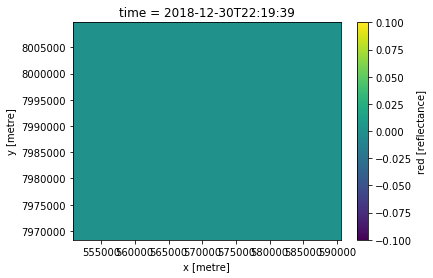

In [43]:
scenes.isel(time = 1).red.plot();

Create + apply 'cleansky' mask

In [40]:
from clean_mask import landsat_qa_clean_mask
clearsky_masks = landsat_qa_clean_mask(scenes, 'SENTINEL_2')
clearsky_scenes = scenes.where(clearsky_masks)

Apply wofs classification

In [41]:
from dc_water_classifier import wofs_classify
water_classes = wofs_classify(scenes, no_data = np.nan, x_coord='x', y_coord = "y")

Visualise wofs summary product

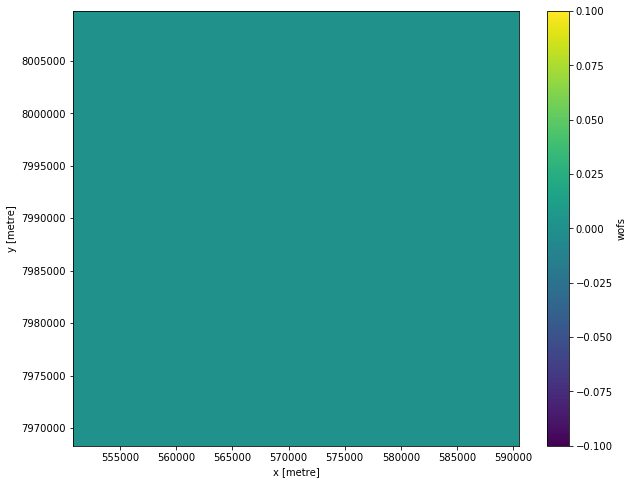

In [42]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()